# PINN for Double Quantum Dot Eigenstates (GaAs)

**Self-contained notebook** - all code embedded, no external dependencies.

Trains Physics-Informed Neural Networks to solve the single-electron Schrödinger eigenproblem for a 2D double quantum dot in GaAs.

**Workflow:**
1. Imports and constants
2. Define physics classes (GaAs, BiquadraticParams)
3. Define SIREN neural network
4. Define loss functions
5. Define training loop and helpers
6. Configure parameters
7. Train GS, ES1, ES2
8. Visualize results

## 1. Imports and Constants

In [1]:
import torch
import torch.nn as nn
import math
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np

torch.set_default_dtype(torch.float64)

# Physical constants (SI)
HBAR = 1.054_571_817e-34  # J*s
E_CHARGE = 1.602_176_634e-19  # C
EPS0 = 8.854_187_8128e-12  # F/m
M0 = 9.109_383_7015e-31  # kg
MEV_IN_J = 1.0e-3 * E_CHARGE

print('✓ Imports successful')
print(f'PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}')

✓ Imports successful
PyTorch: 2.9.0+cu126, CUDA: True


## 2. Physics Classes

In [2]:
@dataclass(frozen=True)
class GaAs:
    m_star_rel: float = 0.067
    eps_r: float = 12.9
    L0_nm: float = 30.0

    @property
    def m_star(self): return self.m_star_rel * M0
    @property
    def L0(self): return self.L0_nm * 1e-9
    @property
    def E0_J(self): return (HBAR**2) / (2.0 * self.m_star * self.L0**2)
    @property
    def E0_meV(self): return self.E0_J / MEV_IN_J

def kappa_from_hbar_omega_meV(hbar_omega_meV: float, mat: GaAs) -> float:
    Eh_J = hbar_omega_meV * MEV_IN_J
    return (mat.m_star**2 * mat.L0**4 / HBAR**4) * Eh_J**2

@dataclass
class BiquadraticParams:
    a: float
    c4: float
    c2y: float
    delta: float = 0.0

def from_targets(a, hbar_omega_x_meV, hbar_omega_y_meV, delta=0.0, mat=None):
    mat = mat or GaAs()
    kx = kappa_from_hbar_omega_meV(hbar_omega_x_meV, mat)
    ky = kappa_from_hbar_omega_meV(hbar_omega_y_meV, mat)
    return BiquadraticParams(a=a, c4=kx/(4*a*a), c2y=ky, delta=delta)

def vectorized_biq_v(p: BiquadraticParams, xy: torch.Tensor):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return p.c4 * (x*x - p.a*p.a)**2 + p.c2y * y*y + p.delta * x

print('✓ Physics classes defined')

✓ Physics classes defined


## 3. SIREN Neural Network

In [3]:
class Sine(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0
    def forward(self, x): return torch.sin(self.w0 * x)

class SIRENLayer(nn.Module):
    def __init__(self, in_features, out_features, w0, is_first):
        super().__init__()
        self.lin = nn.Linear(in_features, out_features)
        self.act = Sine(w0)
        self.is_first, self.w0 = is_first, w0
        with torch.no_grad():
            if is_first:
                self.lin.weight.uniform_(-1.0/in_features, 1.0/in_features)
            else:
                b = math.sqrt(6/in_features)/w0
                self.lin.weight.uniform_(-b, b)
            if self.lin.bias is not None: self.lin.bias.zero_()
    def forward(self, x): return self.act(self.lin(x))

class SIREN(nn.Module):
    def __init__(self, in_features, hidden_features=128, hidden_layers=4, out_features=1, w0=30.0, w0_hidden=1.0):
        super().__init__()
        layers = [SIRENLayer(in_features, hidden_features, w0, True)]
        for _ in range(hidden_layers-1):
            layers.append(SIRENLayer(hidden_features, hidden_features, w0_hidden, False))
        self.net = nn.Sequential(*layers, nn.Linear(hidden_features, out_features))
    def forward(self, x): return self.net(x)

print('✓ SIREN model defined')

✓ SIREN model defined


## 4. Loss Functions

In [4]:
def laplacian(fn, xy):
    with torch.enable_grad():
        xy = xy.detach().requires_grad_(True)
        psi = fn(xy)
        g = torch.autograd.grad(psi, xy, torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
        dx, dy = g[:, 0:1], g[:, 1:2]
        dxx = torch.autograd.grad(dx, xy, torch.ones_like(dx), create_graph=True, retain_graph=True)[0][:, 0:1]
        dyy = torch.autograd.grad(dy, xy, torch.ones_like(dy), create_graph=True, retain_graph=True)[0][:, 1:2]
        return dxx + dyy

def h_psi(fn, vfun, xy):
    with torch.enable_grad():
        return -laplacian(fn, xy) + vfun(xy) * fn(xy)

def rayleigh_ritz_energy(fn, vfun, xy_q, w_q):
    with torch.enable_grad():
        xy = xy_q.detach().requires_grad_(True)
        psi = fn(xy)
        g = torch.autograd.grad(psi, xy, torch.ones_like(psi), create_graph=True, retain_graph=True)[0]
        gsq = (g*g).sum(dim=1, keepdim=True)
        v = vfun(xy)
        num = (w_q * (gsq + v*psi*psi)).sum()
        den = (w_q * psi*psi).sum()
        return num / (den + 1e-12)

def pde_residual_loss(fn, vfun, xy_c):
    psi = fn(xy_c)
    Hpsi = h_psi(fn, vfun, xy_c)
    e_local = (psi*Hpsi).sum(dim=0, keepdim=True) / ((psi*psi).sum(dim=0, keepdim=True) + 1e-12)
    res = Hpsi - e_local*psi
    return (res*res).mean()

def normalization_penalty(model, xy_q, w_q):
    psi = model(xy_q)
    return ((w_q*psi*psi).sum() - 1.0)**2

def orthogonality_loss(psi_new, psi_prev, w_q):
    num = (w_q*psi_new*psi_prev).sum()
    den = torch.sqrt((w_q*psi_new*psi_new).sum() * (w_q*psi_prev*psi_prev).sum() + 1e-12)
    return (num/(den+1e-12))**2

def symmetry_penalty_odd(fn, xy_q, w_q):
    with torch.enable_grad():
        xy_flip = xy_q.clone()
        xy_flip[:, 0:1] = -xy_flip[:, 0:1]
        diff = fn(xy_q) + fn(xy_flip)
        return (w_q*diff*diff).sum() / (w_q.sum() + 1e-12)

def symmetry_penalty_even(fn, xy_q, w_q):
    with torch.enable_grad():
        xy_flip = xy_q.clone()
        xy_flip[:, 0:1] = -xy_flip[:, 0:1]
        diff = fn(xy_q) - fn(xy_flip)
        return (w_q*diff*diff).sum() / (w_q.sum() + 1e-12)

print('✓ Loss functions defined')

✓ Loss functions defined


## 5. Helper Functions

In [5]:
def sample_collocation(X, Y, n, device):
    xy = torch.empty((n, 2), device=device).uniform_(0.0, 1.0)
    xy[:, 0] = (xy[:, 0] * 2.0 - 1.0) * X
    xy[:, 1] = (xy[:, 1] * 2.0 - 1.0) * Y
    return xy

def make_quadrature_box(X, Y, n=128):
    xs = torch.linspace(-X, X, n)
    ys = torch.linspace(-Y, Y, n)
    Xg, Yg = torch.meshgrid(xs, ys, indexing='xy')
    xy = torch.stack([Xg.reshape(-1), Yg.reshape(-1)], dim=-1)
    w = torch.full((xy.shape[0], 1), (2*X/(n-1)) * (2*Y/(n-1)))
    return xy, w

def compute_norm_value(model, xy_q, w_q):
    with torch.no_grad():
        psi = model(xy_q)
        return torch.sum(w_q * psi * psi)

def compute_density_features(xs_t, ys_t, psi_grid_t, a_param=None):
    N_plot = xs_t.numel()
    P = psi_grid_t ** 2
    dx = (xs_t[-1] - xs_t[0]) / (N_plot - 1)
    dy = (ys_t[-1] - ys_t[0]) / (N_plot - 1)
    cell = dx * dy
    total_prob = float((P.sum() * cell).item())
    Xg = xs_t.view(N_plot, 1).expand(N_plot, N_plot)
    Yg = ys_t.view(1, N_plot).expand(N_plot, N_plot)
    com_x = float(((P * Xg).sum() * cell / (total_prob + 1e-12)).item())
    com_y = float(((P * Yg).sum() * cell / (total_prob + 1e-12)).item())
    left_mask = (Xg < 0)
    left_mass = float((P[left_mask].sum() * cell).item())
    right_mass = float((P[~left_mask].sum() * cell).item())
    P_flat = P.reshape(-1)
    vals, idxs = torch.topk(P_flat, k=min(2, P_flat.numel()))
    peaks = []
    for v, idx in zip(vals.tolist(), idxs.tolist()):
        iy = idx % N_plot
        ix = idx // N_plot
        peaks.append({'x': float(xs_t[ix].item()), 'y': float(ys_t[iy].item()), 'p': float(v)})

    # Identify global minimum
    min_val, min_idx_flat = torch.min(P_flat, dim=0)
    min_iy = min_idx_flat % N_plot
    min_ix = min_idx_flat // N_plot
    min_x = float(xs_t[min_ix].item())
    min_y = float(ys_t[min_iy].item())

    return {
        'total_prob': total_prob,
        'com': {'x': com_x, 'y': com_y},
        'side_mass': {'left': left_mass, 'right': right_mass},
        'peaks': peaks,
        'global_min': {'x': min_x, 'y': min_y, 'p': float(min_val.item())}
    }

def save_config_params(file_path, params):
    serializable_params = {}
    for k, v in params.items():
        if isinstance(v, Path): # Convert Path objects to strings
            serializable_params[k] = str(v)
        elif isinstance(v, torch.device): # Convert torch.device to string
            serializable_params[k] = str(v)
        elif isinstance(v, (int, float, str, bool, type(None))):
            serializable_params[k] = v
        elif isinstance(v, dict):
            # Recursively handle nested dictionaries, converting Path/device if present
            temp_dict = {}
            for sub_k, sub_v in v.items():
                if isinstance(sub_v, Path):
                    temp_dict[sub_k] = str(sub_v)
                elif isinstance(sub_v, torch.device):
                    temp_dict[sub_k] = str(sub_v)
                else:
                    temp_dict[sub_k] = sub_v
            serializable_params[k] = temp_dict
        else:
            # Attempt to convert other types to string or rely on json's default
            try:
                serializable_params[k] = str(v)
            except TypeError:
                serializable_params[k] = repr(v) # Fallback to representation

    with open(file_path, 'w') as f:
        json.dump(serializable_params, f, indent=4)

def save_training_history(file_path, history):
    serializable_history = {}
    for key, val_list in history.items():
        serializable_history[key] = [float(v) for v in val_list]
    with open(file_path, 'w') as f:
        json.dump(serializable_history, f, indent=4)

def save_density_features(file_path, features):
    # Features dict already contains basic types, no special conversion needed
    with open(file_path, 'w') as f:
        json.dump(features, f, indent=4)

def save_plot_data(directory, name, xs, ys, psi_grid):
    directory.mkdir(parents=True, exist_ok=True)
    np.save(directory / f'{name}_xs.npy', xs.cpu().numpy())
    np.save(directory / f'{name}_ys.npy', ys.cpu().numpy())
    np.save(directory / f'{name}_psi_grid.npy', psi_grid.cpu().numpy())

def collect_config_params(globals_dict, p_obj, mat_obj):
    config = {
        'device': globals_dict['device'],
        'material': {
            'm_star_rel': mat_obj.m_star_rel,
            'eps_r': mat_obj.eps_r,
            'L0_nm': mat_obj.L0_nm,
            'L0': mat_obj.L0,
            'E0_J': mat_obj.E0_J,
            'E0_meV': mat_obj.E0_meV
        },
        'potential': {
            'a': p_obj.a,
            'c4': p_obj.c4,
            'c2y': p_obj.c2y,
            'delta': p_obj.delta,
            'hbar_omega_x_meV': globals_dict['hbar_omega_x'],
            'hbar_omega_y_meV': globals_dict['hbar_omega_y']
        },
        'computational_domain': {
            'X': globals_dict['X'],
            'Y': globals_dict['Y'],
            'nq': globals_dict['nq'],
            'nc': globals_dict['nc']
        },
        'training_hyperparameters': {
            'epochs': globals_dict['epochs'],
            'lr': globals_dict['lr'],
            'lbfgs_iters': globals_dict['lbfgs_iters']
        },
        'loss_weights': {
            'lam_rr': globals_dict['lam_rr'],
            'lam_pde': globals_dict['lam_pde'],
            'lam_norm': globals_dict['lam_norm'],
            'lam_ortho': globals_dict['lam_ortho'],
            'lam_sym_even': globals_dict['lam_sym_even'],
            'lam_sym_odd': globals_dict['lam_sym_odd']
        },
        'network_architecture': {
            'hidden_features': globals_dict['hidden_features'],
            'hidden_layers': globals_dict['hidden_layers']
        },
        'output_directory': globals_dict['outdir']
    }
    return config

print('✓ Helper saving functions defined')

✓ Helper functions defined


## 6. Training Loop

In [10]:
def train_one_state(model, p, xy_q, w_q, X, Y, epochs=3000, n_colloc=4096, lr=1e-3,
                    lam_rr=1.0, lam_pde=2.5, lam_norm=100.0, device=None, lbfgs_iters=200,
                    lam_ortho=0.0, ref_models=None, lam_sym_odd=0.0, lam_sym_even=0.0):
    device = device or xy_q.device
    vfun_batch = lambda xy: vectorized_biq_v(p, xy)

    # Freeze reference models
    refs = ref_models or []
    for r in refs:
        r.eval()
        for p_ref in r.parameters():
            p_ref.requires_grad_(False)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'E': [], 'Lres': [], 'Lnorm': [], 'NormValue': [], 'Overlap0': []}
    best = {'E': float('inf'), 'state_dict': None}

    # Adam training
    for ep in range(1, epochs + 1):
        model.train()
        xy_c = sample_collocation(X, Y, n_colloc, device)

        E = rayleigh_ritz_energy(model, vfun_batch, xy_q, w_q)
        Lres = pde_residual_loss(model, vfun_batch, xy_c)
        Lnorm = normalization_penalty(model, xy_q, w_q)
        Lsym = 0.0
        if lam_sym_odd > 0.0:
            Lsym += lam_sym_odd * symmetry_penalty_odd(model, xy_q, w_q)
        if lam_sym_even > 0.0:
            Lsym += lam_sym_even * symmetry_penalty_even(model, xy_q, w_q)
        loss = lam_rr * E + lam_pde * Lres + lam_norm * Lnorm + Lsym

        # Orthogonality
        overlap_val = None
        if len(refs) > 0 and lam_ortho > 0.0:
            with torch.no_grad():
                prev_list = [r(xy_q) for r in refs]
            psi_new = model(xy_q)
            overlap_term = 0.0
            overlap_vals = []
            for psi_prev in prev_list:
                osq = orthogonality_loss(psi_new, psi_prev, w_q)
                overlap_term += osq
                overlap_vals.append(torch.sqrt(osq + 1e-12))
            loss += lam_ortho * overlap_term
            if overlap_vals:
                overlap_val = torch.max(torch.stack(overlap_vals))

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        history['E'].append(float(E.detach().cpu()))
        history['Lres'].append(float(Lres.detach().cpu()))
        history['Lnorm'].append(float(Lnorm.detach().cpu()))
        norm_val = compute_norm_value(model, xy_q, w_q)
        history['NormValue'].append(float(norm_val.detach().cpu()))
        if overlap_val is not None:
            history['Overlap0'].append(float(overlap_val.detach().cpu()))

        if E.item() < best['E']:
            best['E'] = float(E.item())
            best['state_dict'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if ep % 50 == 0 or ep == 1:
            msg = f'[ep {ep:5d}] E={E.item():.6f}  Lres={Lres.item():.3e}  Lnorm={Lnorm.item():.3e}  |psi|^2={norm_val.item():.5f}'
            if overlap_val is not None:
                msg += f'  overlap0={overlap_val.item():.3e}'
            print(msg)

    # LBFGS refinement
    if lbfgs_iters > 0:
        print(f'Running LBFGS refinement ({lbfgs_iters} iters)...')
        opt2 = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_iters, line_search_fn='strong_wolfe')

        def closure():
            opt2.zero_grad(set_to_none=True)
            xy_c2 = sample_collocation(X, Y, max(256, n_colloc // 4), device)
            E2 = rayleigh_ritz_energy(model, vfun_batch, xy_q, w_q)
            R2 = pde_residual_loss(model, vfun_batch, xy_c2)
            N2 = normalization_penalty(model, xy_q, w_q)
            Lsym2 = 0.0
            if lam_sym_odd > 0.0:
                Lsym2 += lam_sym_odd * symmetry_penalty_odd(model, xy_q, w_q)
            if lam_sym_even > 0.0:
                Lsym2 += lam_sym_even * symmetry_penalty_even(model, xy_q, w_q)
            loss2 = lam_rr * E2 + lam_pde * R2 + lam_norm * N2 + Lsym2
            if len(refs) > 0 and lam_ortho > 0.0:
                with torch.no_grad():
                    prev_list2 = [r(xy_q) for r in refs]
                psi_new2 = model(xy_q)
                overlap_term2 = 0.0
                for psi_prev2 in prev_list2:
                    osq2 = orthogonality_loss(psi_new2, psi_prev2, w_q)
                    overlap_term2 += osq2
                loss2 += lam_ortho * overlap_term2
            loss2.backward()
            return loss2

        opt2.step(closure)

        # Final evaluation
        with torch.no_grad():
            E2 = rayleigh_ritz_energy(model, vfun_batch, xy_q, w_q)
            e2f = float(E2.detach().cpu())
            if e2f < best['E']:
                best['E'] = e2f
                best['state_dict'] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        print(f'LBFGS done. Final E={best["E"]:.6f}')

    # Load best
    if best['state_dict'] is not None:
        model.load_state_dict(best['state_dict'])

    return {'history': history, 'bestE': best['E']}

print('✓ Training loop defined')

✓ Training loop defined


## 7. Visualization Functions

In [ ]:
def plot_wavefunction_density(xs, ys, psi_grid, title='Wavefunction Density', vmax=None):
    density = psi_grid.cpu().numpy() ** 2
    X, Y = np.meshgrid(xs.cpu().numpy(), ys.cpu().numpy(), indexing='xy')

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.contourf(X, Y, density, levels=50, cmap='viridis', vmax=vmax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, label='|ψ|²')
    plt.tight_layout()
    return fig

def plot_training_curves(history, title='Training History'):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(history['E'])
    axes[0, 0].set_ylabel('Energy')
    axes[0, 0].set_title('Rayleigh-Ritz Energy')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].semilogy(history['Lres'])
    axes[0, 1].set_ylabel('PDE Residual')
    axes[0, 1].set_title('PDE Residual Loss')
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].semilogy(history['Lnorm'])
    axes[1, 0].set_ylabel('Norm Penalty')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_title('Normalization Penalty')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(history['NormValue'])
    axes[1, 1].axhline(1.0, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_ylabel('∫|ψ|² dΩ')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_title('Normalization Value')
    axes[1, 1].grid(True, alpha=0.3)

    if 'Overlap0' in history and len(history['Overlap0']) > 0:
        fig2, ax = plt.subplots(figsize=(8, 4))
        ax.semilogy(history['Overlap0'])
        ax.set_ylabel('Max Overlap')
        ax.set_xlabel('Epoch')
        ax.set_title('Orthogonality (Max Overlap to Refs)')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()

    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    return fig

def plot_and_save_potential(p, X, Y, N_plot, outdir):
    """Generates and saves plots of the potential."""
    print(f'Generating potential plots to {outdir / "potential"}')
    potential_outdir = outdir / 'potential'
    potential_outdir.mkdir(parents=True, exist_ok=True)

    # Generate grid
    xs_plot = torch.linspace(-X, X, N_plot)
    ys_plot = torch.linspace(-Y, Y, N_plot)
    Xg_plot, Yg_plot = torch.meshgrid(xs_plot, ys_plot, indexing='xy')
    xy_plot = torch.stack([Xg_plot.reshape(-1), Yg_plot.reshape(-1)], dim=-1)

    # Calculate potential values
    potential_values = vectorized_biq_v(p, xy_plot).cpu().numpy()
    potential_grid = potential_values.reshape(N_plot, N_plot)
    
    # ==========================================
    # VISUALIZATION FIX: NaN Masking
    # ==========================================
    V_vis_max = 20.0
    pot_min = potential_grid.min()
    
    # Create a copy for plotting where high values are invisible
    # We use np.nan (Not a Number) to make matplotlib ignore these points
    pot_masked = potential_grid.copy()
    pot_masked[pot_masked > V_vis_max] = np.nan

    # 1. 2D Density Plot (Background will be white/transparent)
    fig_density, ax_density = plt.subplots(figsize=(8, 6))
    
    # We plot the MASKED grid. 
    # The 'bad' color (NaNs) will be white by default in contourf if we don't set a background
    levels = np.linspace(pot_min, V_vis_max, 100) # More levels for smoothness
    
    im_density = ax_density.contourf(
        Xg_plot.cpu().numpy(), Yg_plot.cpu().numpy(), pot_masked, 
        levels=levels, cmap='inferno'
    )
    
    ax_density.set_xlabel('x')
    ax_density.set_ylabel('y')
    ax_density.set_title(f'Potential V(x, y) (Clipped at {V_vis_max})')
    ax_density.set_aspect('equal')
    
    # Fix the colorbar to match the visual range
    plt.colorbar(im_density, ax=ax_density, label='Potential Energy')
    
    plt.tight_layout()
    fig_density.savefig(potential_outdir / 'potential_density.png', dpi=150, bbox_inches='tight')
    plt.close(fig_density)

    # 2. 3D Surface Plot 
    fig_3d = plt.figure(figsize=(12, 10)) 
    ax_3d = fig_3d.add_subplot(111, projection='3d')
    
    # Plot the MASKED surface. 
    surf = ax_3d.plot_surface(
        Xg_plot.cpu().numpy(), Yg_plot.cpu().numpy(), pot_masked, 
        cmap='inferno', 
        edgecolor='none',
        rcount=100, ccount=100,
        vmin=pot_min, vmax=V_vis_max,
        alpha=0.9
    )
    
    ax_3d.set_xlabel('x')
    ax_3d.set_ylabel('y')
    ax_3d.set_zlabel('Potential Energy')
    ax_3d.set_title('3D Potential Surface')
    
    ax_3d.set_zlim(pot_min, V_vis_max)
    ax_3d.view_init(elev=45, azim=-45) 
    
    plt.tight_layout()
    fig_3d.savefig(potential_outdir / 'potential_3d_surface.png', dpi=150, bbox_inches='tight')
    plt.close(fig_3d)

    # 3. Slice Views
    # Use unmasked grid for slices, but limit the Y-axis view
    
    # X-Slice
    y_slice_idx = torch.argmin(torch.abs(ys_plot - 0.0))
    x_slice_potential = potential_grid[y_slice_idx, :] # Use original grid

    fig_slice_x, ax_slice_x = plt.subplots(figsize=(8, 5))
    ax_slice_x.plot(xs_plot.cpu().numpy(), x_slice_potential, color='black')
    # Fill up to V_vis_max only
    ax_slice_x.fill_between(xs_plot.cpu().numpy(), x_slice_potential, V_vis_max, where=(x_slice_potential < V_vis_max), alpha=0.1, color='orange')
    
    ax_slice_x.set_xlabel('x')
    ax_slice_x.set_ylabel('Potential Energy')
    ax_slice_x.set_title('Potential Slice at y=0')
    ax_slice_x.grid(True, alpha=0.3)
    ax_slice_x.set_ylim(pot_min - 1.0, V_vis_max) # Zoom in
    plt.tight_layout()
    fig_slice_x.savefig(potential_outdir / 'potential_slice_y0.png', dpi=150, bbox_inches='tight')
    plt.close(fig_slice_x)

    # Y-Slice
    x_slice_idx = torch.argmin(torch.abs(xs_plot - 0.0))
    y_slice_potential = potential_grid[:, x_slice_idx] # Use original grid

    fig_slice_y, ax_slice_y = plt.subplots(figsize=(8, 5))
    ax_slice_y.plot(ys_plot.cpu().numpy(), y_slice_potential, color='black')
    ax_slice_y.fill_between(ys_plot.cpu().numpy(), y_slice_potential, V_vis_max, where=(y_slice_potential < V_vis_max), alpha=0.1, color='orange')
    
    ax_slice_y.set_xlabel('y')
    ax_slice_y.set_ylabel('Potential Energy')
    ax_slice_y.set_title('Potential Slice at x=0')
    ax_slice_y.grid(True, alpha=0.3)
    ax_slice_y.set_ylim(pot_min - 1.0, V_vis_max) # Zoom in
    plt.tight_layout()
    fig_slice_y.savefig(potential_outdir / 'potential_slice_x0.png', dpi=150, bbox_inches='tight')
    plt.close(fig_slice_y)

    print('✓ Potential plots generated and saved.')

print('✓ Visualization functions defined')

✓ Visualization functions defined


## 8. Configuration

In [8]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Material
mat = GaAs()
print(f'GaAs: L0={mat.L0_nm} nm, E0={mat.E0_meV:.3f} meV')

# Potential parameters
a = 1.5  # well separation
hbar_omega_x = 3.0  # meV
hbar_omega_y = 5.0  # meV
delta = 0.0  # asymmetry
p = from_targets(a, hbar_omega_x, hbar_omega_y, delta, mat)
print(f'Potential: a={p.a}, c4={p.c4:.4f}, c2y={p.c2y:.4f}, δ={p.delta}')

# Computational domain
X, Y = 4.0, 4.0
nq = 128  # quadrature grid
nc = 8192  # collocation points

# Training hyperparameters
epochs = 2000
lr = 1e-3
lbfgs_iters = 200

# Loss weights
lam_rr = 1.0
lam_pde = 2.5
lam_norm = 100.0
lam_ortho = 20.0  # for excited states

# Parity weights (for symmetric case δ=0)
lam_sym_even = 0.1  # GS, ES2
lam_sym_odd = 0.1   # ES1

# Network architecture
hidden_features = 128
hidden_layers = 6

# Create quadrature grid
xy_q, w_q = make_quadrature_box(X, Y, nq)
xy_q = xy_q.to(device)
w_q = w_q.to(device)
print(f'Quadrature grid: {xy_q.shape[0]} points')

# Output directory
outdir = Path('colab_results')
outdir.mkdir(exist_ok=True)
print(f'Results will be saved to: {outdir}')

print('\
✓ Configuration complete')

Using device: cuda
GaAs: L0=30.0 nm, E0=0.632 meV
Potential: a=1.5, c4=0.6262, c2y=15.6556, δ=0.0
Quadrature grid: 16384 points
Results will be saved to: colab_results
✓ Configuration complete


## 9. Train Ground State (GS)

Train the ground state with optional even-parity bias (for symmetric δ=0 case).

In [11]:
print('='*60)
print('TRAINING GROUND STATE (GS)')
print('='*60)

model_gs = SIREN(in_features=2, hidden_features=hidden_features, hidden_layers=hidden_layers).to(device)

result_gs = train_one_state(
    model_gs, p, xy_q, w_q, X, Y,
    epochs=epochs,
    n_colloc=nc,
    lr=lr,
    lam_rr=lam_rr,
    lam_pde=lam_pde,
    lam_norm=lam_norm,
    device=device,
    lbfgs_iters=lbfgs_iters,
    lam_sym_even=0.0 #if delta == 0.0 else 0.0
)

E_gs = result_gs['bestE']
print(f'\
✓ GS training complete. E_GS = {E_gs:.6f} (dimensionless)')
print(f'  E_GS = {E_gs * mat.E0_meV:.4f} meV')

# Save model
torch.save(model_gs.state_dict(), outdir / 'model_gs.pt')
with open(outdir / 'energies.txt', 'w') as f:
    f.write(f'E_GS = {E_gs:.8f}  ({E_gs * mat.E0_meV:.6f} meV)\
')

TRAINING GROUND STATE (GS)
[ep     1] E=416.676949  Lres=3.133e+04  Lnorm=5.689e+01  |psi|^2=5.60544
[ep    50] E=192.232305  Lres=5.959e+01  Lnorm=8.747e-01  |psi|^2=0.06077
[ep   100] E=37.148985  Lres=3.765e+00  Lnorm=9.051e-01  |psi|^2=0.05088
[ep   150] E=30.865719  Lres=1.426e+01  Lnorm=7.448e-02  |psi|^2=0.73145
[ep   200] E=17.469475  Lres=8.008e+00  Lnorm=1.222e-02  |psi|^2=0.88388
[ep   250] E=10.074947  Lres=3.300e+00  Lnorm=9.617e-03  |psi|^2=0.89347
[ep   300] E=8.659600  Lres=1.944e+00  Lnorm=3.510e-03  |psi|^2=0.98304
[ep   350] E=8.208990  Lres=2.128e+00  Lnorm=1.383e-04  |psi|^2=0.99101
[ep   400] E=7.443755  Lres=1.245e+00  Lnorm=1.645e-03  |psi|^2=0.95139
[ep   450] E=7.042699  Lres=9.971e-01  Lnorm=8.949e-04  |psi|^2=1.00351
[ep   500] E=6.699447  Lres=7.229e-01  Lnorm=1.930e-07  |psi|^2=0.97849
[ep   550] E=6.448984  Lres=4.792e-01  Lnorm=3.535e-04  |psi|^2=1.00331
[ep   600] E=6.349380  Lres=4.570e-01  Lnorm=4.980e-07  |psi|^2=0.98158
[ep   650] E=6.252489  Lres=3

## 10. Visualize Ground State

GS Density Features:
  COM: (0.0029, -0.0399)
  Side mass: L=0.4977, R=0.5023
  Top 2 peaks: [{'x': 0.020100502512562755, 'y': -1.1055276381909547, 'p': 0.32649846964916346}, {'x': 0.020100502512562755, 'y': -1.1457286432160803, 'p': 0.3263456665198455}]


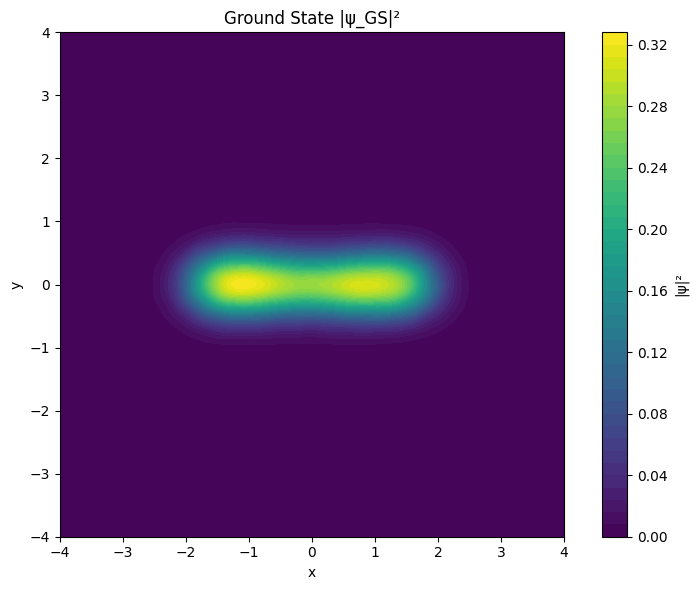

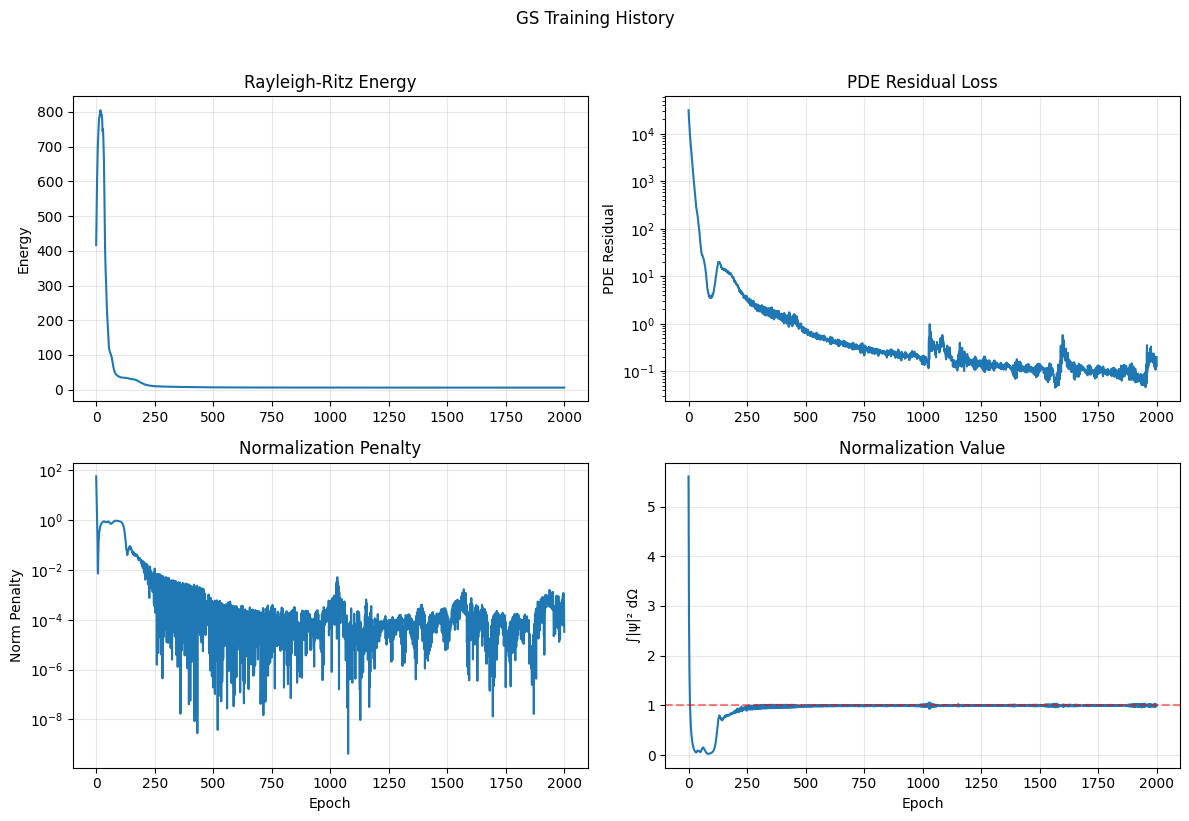


✓ GS results saved to colab_results/gs


In [36]:
import matplotlib.pyplot as plt

# Evaluate on grid
N_plot = 200
xs_plot = torch.linspace(-X, X, N_plot)
ys_plot = torch.linspace(-Y, Y, N_plot)
Xg_plot, Yg_plot = torch.meshgrid(xs_plot, ys_plot, indexing='xy')
xy_plot = torch.stack([Xg_plot.reshape(-1), Yg_plot.reshape(-1)], dim=-1).to(device)

with torch.no_grad():
    psi_gs_flat = model_gs(xy_plot).cpu()
psi_gs_grid = psi_gs_flat.reshape(N_plot, N_plot)

# Normalize for visualization
dx_plot = (xs_plot[-1] - xs_plot[0]) / (N_plot - 1)
dy_plot = (ys_plot[-1] - ys_plot[0]) / (N_plot - 1)
norm_plot = (psi_gs_grid**2).sum() * dx_plot * dy_plot
psi_gs_grid = psi_gs_grid / torch.sqrt(norm_plot + 1e-12)

# Compute features
features_gs = compute_density_features(xs_plot, ys_plot, psi_gs_grid, a_param=p.a)
print('GS Density Features:')
print(f'  COM: ({features_gs["com"]["x"]:.4f}, {features_gs["com"]["y"]:.4f})')
print(f'  Side mass: L={features_gs["side_mass"]["left"]:.4f}, R={features_gs["side_mass"]["right"]:.4f}')
print(f'  Top 2 peaks: {features_gs["peaks"]}')
print(f'  Global Min: ({features_gs["global_min"]["x"]:.4f}, {features_gs["global_min"]["y"]:.4f}) p={features_gs["global_min"]["p"]:.4e}')

# Plot
fig_gs = plot_wavefunction_density(xs_plot, ys_plot, psi_gs_grid, title='Ground State |ψ_GS|²')
plt.show()

fig_hist_gs = plot_training_curves(result_gs['history'], title='GS Training History')
plt.show()

# --- Save Results for GS ---
gs_output_dir = outdir / 'gs'
gs_output_dir.mkdir(exist_ok=True)

# Save config parameters
config_params = collect_config_params(globals(), p, mat)
save_config_params(gs_output_dir / 'config.json', config_params)

# Save GS energy
with open(gs_output_dir / 'energy_gs.json', 'w') as f:
    json.dump({'E_gs_dimensionless': E_gs, 'E_gs_meV': E_gs * mat.E0_meV}, f, indent=4)

# Save density features
save_density_features(gs_output_dir / 'density_features.json', features_gs)

# Save training history
save_training_history(gs_output_dir / 'training_history.json', result_gs['history'])

# Save plot data (xs, ys, psi_grid)
save_plot_data(gs_output_dir, 'gs_wavefunction', xs_plot, ys_plot, psi_gs_grid)

# Save figures
fig_gs.savefig(gs_output_dir / 'gs_density.png', dpi=150, bbox_inches='tight')
fig_hist_gs.savefig(gs_output_dir / 'gs_training_history.png', dpi=150, bbox_inches='tight')
plt.close(fig_gs)
plt.close(fig_hist_gs)
print(f'\n✓ GS results saved to {gs_output_dir}')

## 11. Train First Excited State (ES1)

Train ES1 orthogonal to GS, with optional odd-parity bias (for symmetric δ=0 case).

In [13]:
print('='*60)
print('TRAINING FIRST EXCITED STATE (ES1)')
print('='*60)

model_es1 = SIREN(in_features=2, hidden_features=hidden_features, hidden_layers=hidden_layers).to(device)

result_es1 = train_one_state(
    model_es1, p, xy_q, w_q, X, Y,
    epochs=epochs,
    n_colloc=nc,
    lr=lr,
    lam_rr=lam_rr,
    lam_pde=lam_pde,
    lam_norm=lam_norm,
    device=device,
    lbfgs_iters=lbfgs_iters,
    lam_ortho=lam_ortho,
    ref_models=[model_gs],
    lam_sym_odd=lam_sym_odd if delta == 0.0 else 0.0
)

E_es1 = result_es1['bestE']
print(f'\
✓ ES1 training complete. E_ES1 = {E_es1:.6f} (dimensionless)')
print(f'  E_ES1 = {E_es1 * mat.E0_meV:.4f} meV')
print(f'  Splitting: ΔE = {(E_es1 - E_gs) * mat.E0_meV:.4f} meV')

# Save
torch.save(model_es1.state_dict(), outdir / 'model_es1.pt')
with open(outdir / 'energies.txt', 'a') as f:
    f.write(f'E_ES1 = {E_es1:.8f}  ({E_es1 * mat.E0_meV:.6f} meV)\
')
    f.write(f'ΔE(ES1-GS) = {(E_es1-E_gs):.8f}  ({(E_es1-E_gs) * mat.E0_meV:.6f} meV)\
')

TRAINING FIRST EXCITED STATE (ES1)
[ep     1] E=341.126520  Lres=1.830e+04  Lnorm=7.148e+01  |psi|^2=6.13201  overlap0=4.354e-03
[ep    50] E=118.299105  Lres=3.191e+01  Lnorm=7.781e-01  |psi|^2=0.13196  overlap0=3.322e-01
[ep   100] E=39.246015  Lres=2.998e+00  Lnorm=9.338e-01  |psi|^2=0.03378  overlap0=6.050e-01
[ep   150] E=29.741686  Lres=1.505e+01  Lnorm=5.463e-02  |psi|^2=0.77511  overlap0=6.296e-01
[ep   200] E=22.774975  Lres=9.332e+00  Lnorm=1.868e-02  |psi|^2=0.87944  overlap0=6.729e-01
[ep   250] E=13.864657  Lres=3.667e+00  Lnorm=1.807e-03  |psi|^2=0.93197  overlap0=7.651e-01
[ep   300] E=10.876671  Lres=1.888e+00  Lnorm=2.735e-03  |psi|^2=0.95256  overlap0=8.252e-01
[ep   350] E=9.934171  Lres=1.409e+00  Lnorm=2.058e-06  |psi|^2=0.99927  overlap0=8.483e-01
[ep   400] E=9.243594  Lres=1.030e+00  Lnorm=1.248e-03  |psi|^2=0.96743  overlap0=8.638e-01
[ep   450] E=8.933054  Lres=1.053e+00  Lnorm=5.123e-06  |psi|^2=0.99468  overlap0=8.482e-01
[ep   500] E=9.042133  Lres=1.121e+0

## 12. Visualize First Excited State

ES1 Density Features:
  COM: (0.0008, 0.0225)
  Side mass: L=0.4996, R=0.5004
  Top 2 peaks: [{'x': -0.020100502512562755, 'y': 1.3869346733668342, 'p': 0.4905681150676881}, {'x': 0.020100502512562755, 'y': 1.3869346733668342, 'p': 0.4904273408117865}]
  Global Min: (3.5176, 1.8693) p=4.2566e-15


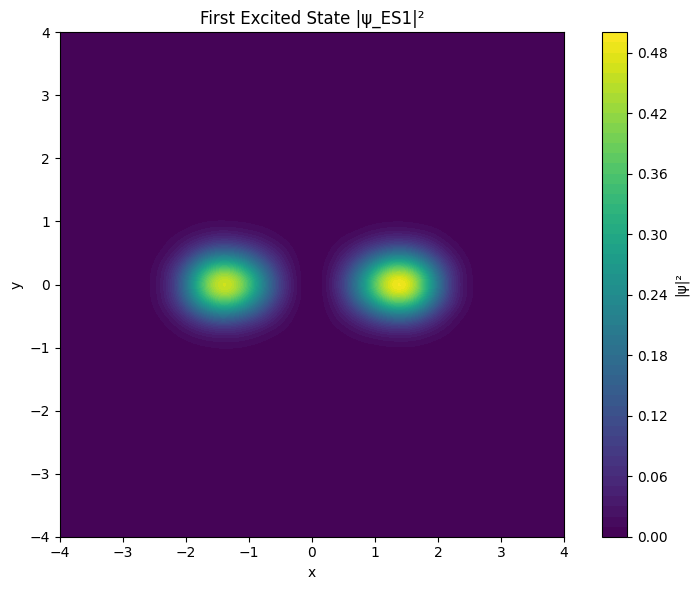

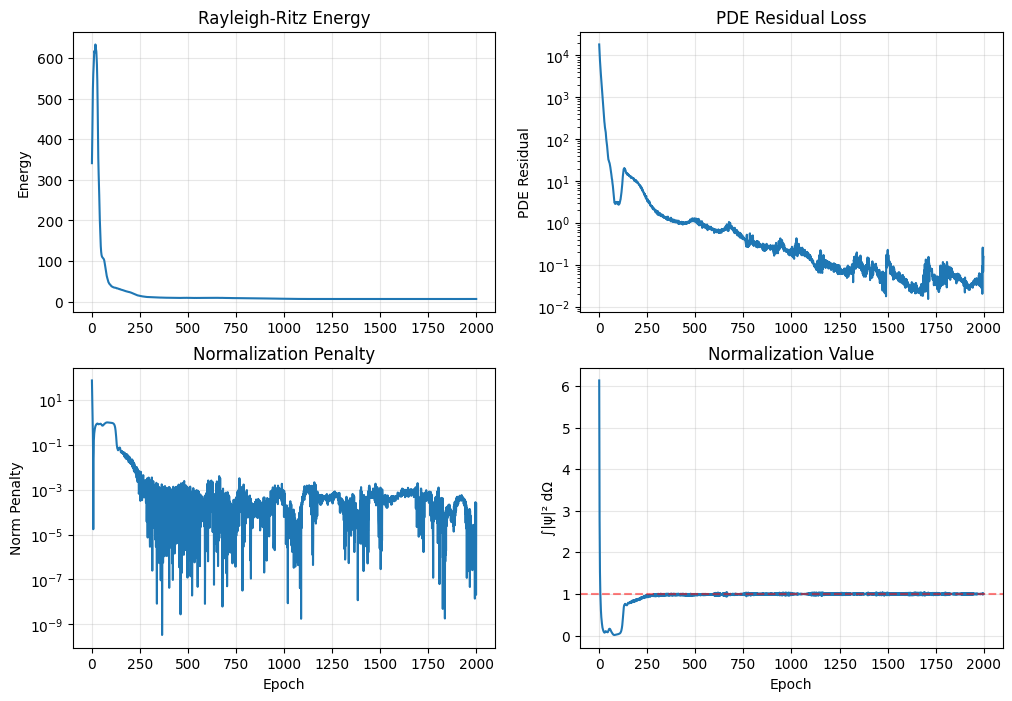

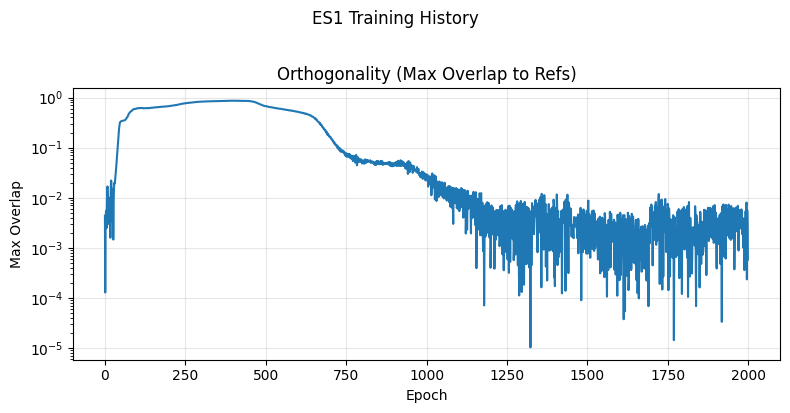


✓ ES1 results saved to colab_results/es1


In [44]:
with torch.no_grad():
    psi_es1_flat = model_es1(xy_plot).cpu()
psi_es1_grid = psi_es1_flat.reshape(N_plot, N_plot)
norm_plot_es1 = (psi_es1_grid**2).sum() * dx_plot * dy_plot
psi_es1_grid = psi_es1_grid / torch.sqrt(norm_plot_es1 + 1e-12)

features_es1 = compute_density_features(xs_plot, ys_plot, psi_es1_grid, a_param=p.a)
print('ES1 Density Features:')
print(f'  COM: ({features_es1["com"]["x"]:.4f}, {features_es1["com"]["y"]:.4f})')
print(f'  Side mass: L={features_es1["side_mass"]["left"]:.4f}, R={features_es1["side_mass"]["right"]:.4f}')
print(f'  Top 2 peaks: {features_es1["peaks"]}')
print(f'  Global Min: ({features_es1["global_min"]["x"]:.4f}, {features_es1["global_min"]["y"]:.4f}) p={features_es1["global_min"]["p"]:.4e}')

fig_es1 = plot_wavefunction_density(xs_plot, ys_plot, psi_es1_grid, title='First Excited State |ψ_ES1|²')
plt.show()

fig_hist_es1 = plot_training_curves(result_es1['history'], title='ES1 Training History')
plt.show()

# --- Save Results for ES1 ---
es1_output_dir = outdir / 'es1'
es1_output_dir.mkdir(exist_ok=True)

# Save config parameters (same for all states, but saved per state folder for completeness)
save_config_params(es1_output_dir / 'config.json', config_params)

# Save ES1 energy
with open(es1_output_dir / 'energy_es1.json', 'w') as f:
    json.dump({'E_es1_dimensionless': E_es1, 'E_es1_meV': E_es1 * mat.E0_meV, 'delta_E_es1_gs_dimensionless': E_es1 - E_gs, 'delta_E_es1_gs_meV': (E_es1 - E_gs) * mat.E0_meV}, f, indent=4)

# Save density features
save_density_features(es1_output_dir / 'density_features.json', features_es1)

# Save training history
save_training_history(es1_output_dir / 'training_history.json', result_es1['history'])

# Save plot data (xs, ys, psi_grid)
save_plot_data(es1_output_dir, 'es1_wavefunction', xs_plot, ys_plot, psi_es1_grid)

# Save figures
fig_es1.savefig(es1_output_dir / 'es1_density.png', dpi=150, bbox_inches='tight')
fig_hist_es1.savefig(es1_output_dir / 'es1_training_history.png', dpi=150, bbox_inches='tight')
plt.close(fig_es1)
plt.close(fig_hist_es1)
print(f'\n✓ ES1 results saved to {es1_output_dir}')

## 13. Train Second Excited State (ES2)

Train ES2 orthogonal to both GS and ES1, with optional even-parity bias.

In [24]:
print('='*60)
print('TRAINING SECOND EXCITED STATE (ES2)')
print('='*60)

model_es2 = SIREN(in_features=2, hidden_features=hidden_features, hidden_layers=hidden_layers).to(device)

result_es2 = train_one_state(
    model_es2, p, xy_q, w_q, X, Y,
    epochs=epochs,
    n_colloc=nc,
    lr=lr,
    lam_rr=lam_rr,
    lam_pde=3.0,
    lam_norm=lam_norm,
    device=device,
    lbfgs_iters=lbfgs_iters,
    lam_ortho=lam_ortho,
    ref_models=[model_gs, model_es1],
    lam_sym_even=0.0 #if delta == 0.0 else 0.0
)

E_es2 = result_es2['bestE']
print(f'\
✓ ES2 training complete. E_ES2 = {E_es2:.6f} (dimensionless)')
print(f'  E_ES2 = {E_es2 * mat.E0_meV:.4f} meV')
print(f'  Splitting: ΔE(ES2-ES1) = {(E_es2 - E_es1) * mat.E0_meV:.4f} meV')

# Save
torch.save(model_es2.state_dict(), outdir / 'model_es2.pt')
with open(outdir / 'energies.txt', 'a') as f:
    f.write(f'E_ES2 = {E_es2:.8f}  ({E_es2 * mat.E0_meV:.6f} meV)\
')
    f.write(f'ΔE(ES2-ES1) = {(E_es2-E_es1):.8f}  ({(E_es2-E_es1) * mat.E0_meV:.6f} meV)\
')

TRAINING SECOND EXCITED STATE (ES2)
[ep     1] E=567.876540  Lres=6.791e+04  Lnorm=2.797e+01  |psi|^2=3.61281  overlap0=7.062e-02
[ep    50] E=108.516421  Lres=3.009e+01  Lnorm=6.880e-01  |psi|^2=0.17042  overlap0=3.442e-01
[ep   100] E=61.043302  Lres=2.898e+00  Lnorm=9.823e-01  |psi|^2=0.00958  overlap0=5.440e-01
[ep   150] E=33.944747  Lres=1.970e+00  Lnorm=9.498e-01  |psi|^2=0.02920  overlap0=6.255e-01
[ep   200] E=29.858827  Lres=1.249e+01  Lnorm=5.251e-02  |psi|^2=0.74930  overlap0=6.191e-01
[ep   250] E=23.803191  Lres=9.438e+00  Lnorm=1.450e-02  |psi|^2=0.82313  overlap0=6.601e-01
[ep   300] E=19.833835  Lres=5.218e+00  Lnorm=1.137e-02  |psi|^2=0.88707  overlap0=6.853e-01
[ep   350] E=16.752007  Lres=3.852e+00  Lnorm=1.745e-03  |psi|^2=0.95513  overlap0=7.131e-01
[ep   400] E=14.433969  Lres=2.981e+00  Lnorm=3.038e-03  |psi|^2=0.94087  overlap0=7.298e-01
[ep   450] E=13.239154  Lres=2.222e+00  Lnorm=6.761e-04  |psi|^2=0.94862  overlap0=6.880e-01
[ep   500] E=13.051446  Lres=1.6

## 14. Visualize Second Excited State

ES2 Density Features:
  COM: (0.0010, 0.0036)
  Side mass: L=0.4986, R=0.5014
  Top 2 peaks: [{'x': 0.020100502512562755, 'y': -0.020100502512562755, 'p': 0.4740310142674239}, {'x': 0.020100502512562755, 'y': 0.020100502512562755, 'p': 0.47390795583507495}]


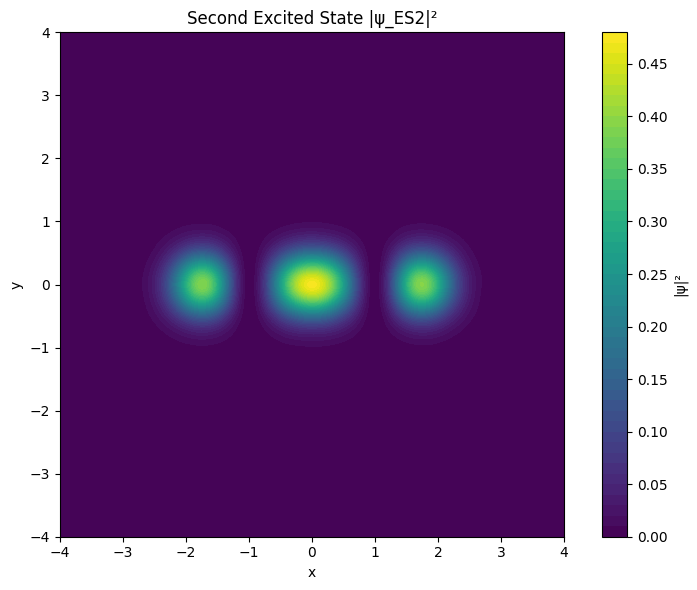

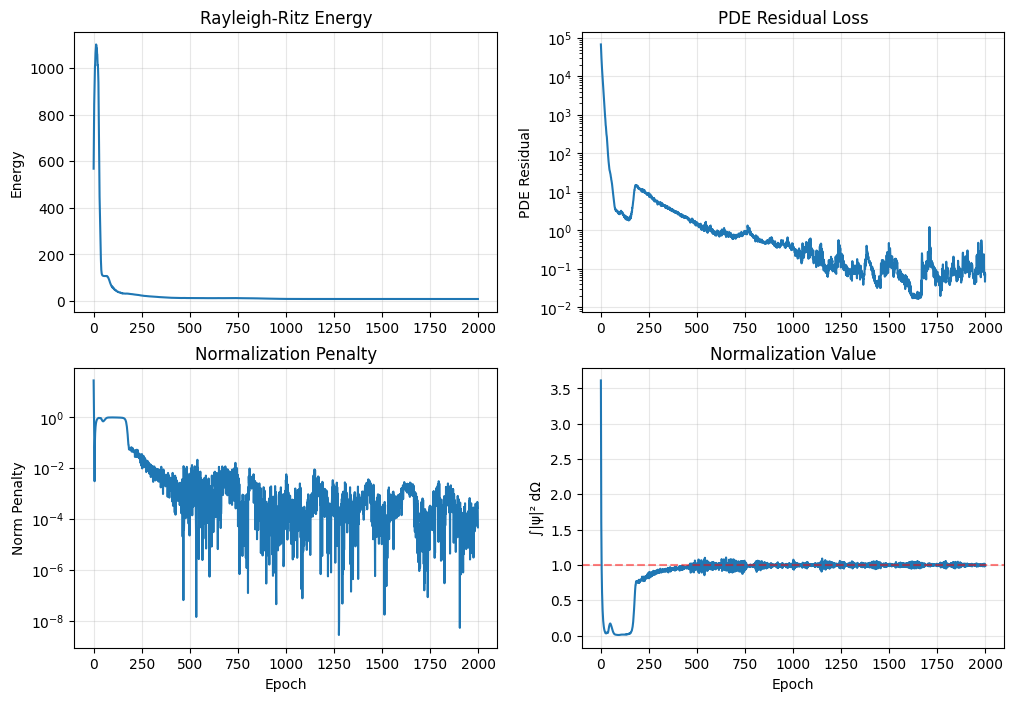

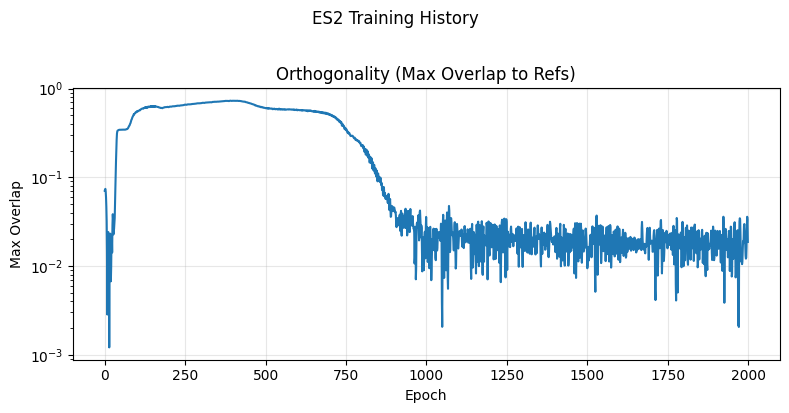

In [33]:
with torch.no_grad():
    psi_es2_flat = model_es2(xy_plot).cpu()
psi_es2_grid = psi_es2_flat.reshape(N_plot, N_plot)
norm_plot_es2 = (psi_es2_grid**2).sum() * dx_plot * dy_plot
psi_es2_grid = psi_es2_grid / torch.sqrt(norm_plot_es2 + 1e-12)

features_es2 = compute_density_features(xs_plot, ys_plot, psi_es2_grid, a_param=p.a)
print('ES2 Density Features:')
print(f'  COM: ({features_es2["com"]["x"]:.4f}, {features_es2["com"]["y"]:.4f})')
print(f'  Side mass: L={features_es2["side_mass"]["left"]:.4f}, R={features_es2["side_mass"]["right"]:.4f}')
print(f'  Top 2 peaks: {features_es2["peaks"]}')
print(f'  Global Min: ({features_es2["global_min"]["x"]:.4f}, {features_es2["global_min"]["y"]:.4f}) p={features_es2["global_min"]["p"]:.4e}')

fig_es2 = plot_wavefunction_density(xs_plot, ys_plot, psi_es2_grid, title='Second Excited State |ψ_ES2|²')
plt.show()

fig_hist_es2 = plot_training_curves(result_es2['history'], title='ES2 Training History')
plt.show()

# --- Save Results for ES2 ---
es2_output_dir = outdir / 'es2'
es2_output_dir.mkdir(exist_ok=True)

# Save config parameters (same for all states, but saved per state folder for completeness)
save_config_params(es2_output_dir / 'config.json', config_params)

# Save ES2 energy
with open(es2_output_dir / 'energy_es2.json', 'w') as f:
    json.dump({'E_es2_dimensionless': E_es2, 'E_es2_meV': E_es2 * mat.E0_meV, 'delta_E_es2_es1_dimensionless': E_es2 - E_es1, 'delta_E_es2_es1_meV': (E_es2 - E_es1) * mat.E0_meV}, f, indent=4)

# Save density features
save_density_features(es2_output_dir / 'density_features.json', features_es2)

# Save training history
save_training_history(es2_output_dir / 'training_history.json', result_es2['history'])

# Save plot data (xs, ys, psi_grid)
save_plot_data(es2_output_dir, 'es2_wavefunction', xs_plot, ys_plot, psi_es2_grid)

# Save figures
fig_es2.savefig(es2_output_dir / 'es2_density.png', dpi=150, bbox_inches='tight')
fig_hist_es2.savefig(es2_output_dir / 'es2_training_history.png', dpi=150, bbox_inches='tight')
plt.close(fig_es2)
plt.close(fig_hist_es2)
print(f'\n✓ ES2 results saved to {es2_output_dir}')

## 15. Summary

TRAINING SUMMARY
Material: GaAs (L0=30.0 nm, E0=0.632 meV)
Potential: a=1.5, ħωx=3.0 meV, ħωy=5.0 meV, δ=0.0

Energies (dimensionless):
  E_GS  = 5.91289838
  E_ES1 = 6.29149081  (ΔE = 0.37859243)
  E_ES2 = 8.90979050  (ΔE = 2.61829969)

Energies (meV):
  E_GS  = 3.735993 meV
  E_ES1 = 3.975202 meV  (ΔE = 0.239209 meV)
  E_ES2 = 5.629543 meV  (ΔE = 1.654341 meV)

Results saved to: colab_results


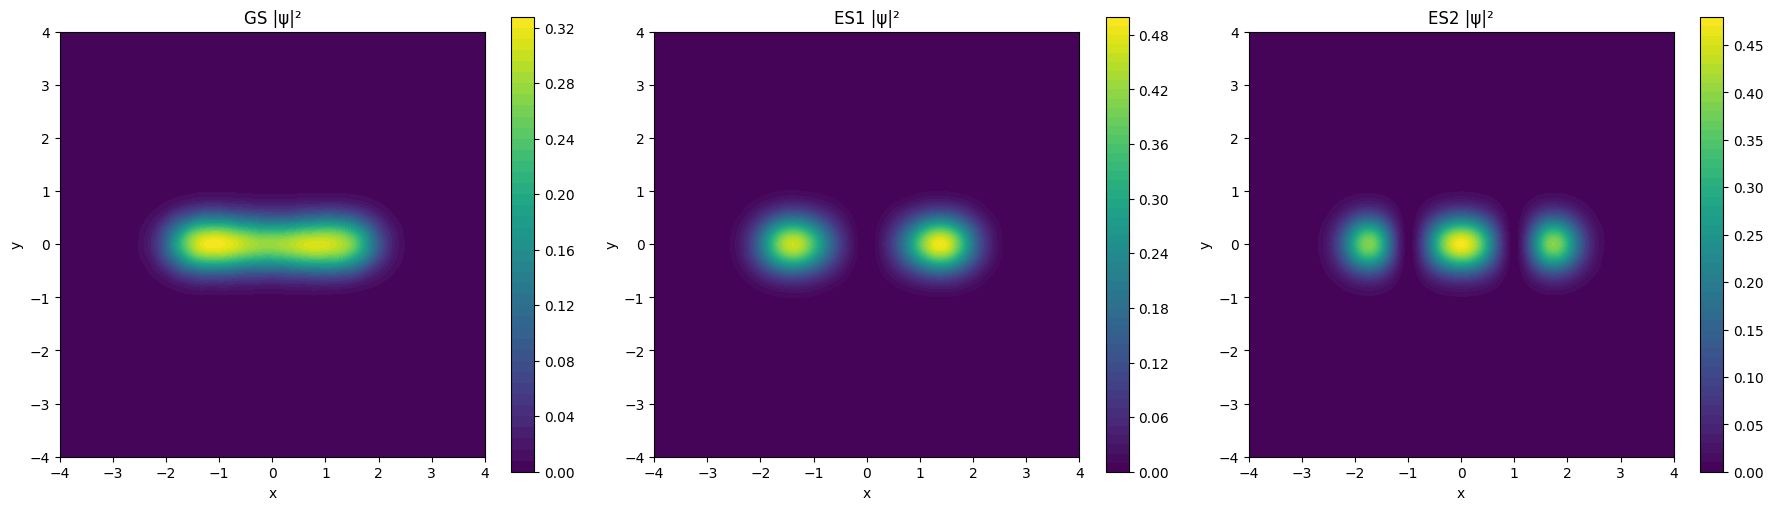

✓ All done! Check the colab_results/ directory for saved models and plots.


In [34]:
print('='*60)
print('TRAINING SUMMARY')
print('='*60)
print(f'Material: GaAs (L0={mat.L0_nm} nm, E0={mat.E0_meV:.3f} meV)')
print(f'Potential: a={p.a}, ħωx={hbar_omega_x} meV, ħωy={hbar_omega_y} meV, δ={delta}')
print()
print('Energies (dimensionless):')
print(f'  E_GS  = {E_gs:.8f}')
print(f'  E_ES1 = {E_es1:.8f}  (ΔE = {E_es1-E_gs:.8f})')
print(f'  E_ES2 = {E_es2:.8f}  (ΔE = {E_es2-E_es1:.8f})')
print()
print('Energies (meV):')
print(f'  E_GS  = {E_gs * mat.E0_meV:.6f} meV')
print(f'  E_ES1 = {E_es1 * mat.E0_meV:.6f} meV  (ΔE = {(E_es1-E_gs) * mat.E0_meV:.6f} meV)')
print(f'  E_ES2 = {E_es2 * mat.E0_meV:.6f} meV  (ΔE = {(E_es2-E_es1) * mat.E0_meV:.6f} meV)')
print()
print(f'Results saved to: {outdir}')
print('='*60)

N_plot_potential = 200 # Use the same plot resolution as for wavefunctions or define a new one
plot_and_save_potential(p, X, Y, N_plot_potential, outdir)

# Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, psi_grid, title in zip(axes, [psi_gs_grid, psi_es1_grid, psi_es2_grid], ['GS', 'ES1', 'ES2']):
    density = psi_grid.cpu().numpy() ** 2
    X_mesh, Y_mesh = np.meshgrid(xs_plot.cpu().numpy(), ys_plot.cpu().numpy(), indexing='xy')
    im = ax.contourf(X_mesh, Y_mesh, density, levels=50, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{title} |ψ|²')
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.savefig(outdir / 'all_states.png', dpi=150, bbox_inches='tight')
plt.show()

print('\
✓ All done! Check the colab_results/ directory for saved models and plots.')